# Neural Network Model, Trained on Limited Dataset
## Model Dataset Limited by SOCAT Sampling Locations

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-11 15:21:18.294577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
recon_model_path = '/home/julias/MLEE-final-project/models/saved_models/recon_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [3]:
X_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
X_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
X_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')

In [4]:
# X_ds.SSS[0,:,:].plot()

## Create Original Dataframes

In [5]:
X_df = X_ds.to_dataframe().dropna()
y_df = y_ds.to_dataframe().dropna()
X_train_df = X_train_ds.to_dataframe().dropna()
y_train_df = y_train_ds.to_dataframe().dropna()
X_test_df = X_test_ds.to_dataframe().dropna()
y_test_df = y_test_ds.to_dataframe().dropna()

In [ ]:
#X_df_norm

In [ ]:
# X_train_ds.SSS[0,:,:].plot()

In [ ]:
# for future for loop to open datasets
#ds_name = {'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test'}
#ds_list = {'X_ds', 'y_ds', 'X_train_ds', 'y_train_ds', 'X_test_ds', 'y_test_ds'}

#ddict = {'X': 'X_ds', 
#         'y': 'y_ds', 
#         'X_train': 'X_train_ds', 
#         'y_train': 'y_train_ds',
#         'X_test': 'X_test_ds',
#         'y_test': 'y_test_ds',
#        }
#data_path = '/home/julias/MLEE-final-project/proc_data/split_datasets/{}.nc'

#for key in ddict:
#    #print(key, 'corresponds to', ddict[key])
#    ddict[key] = xr.open_dataset(data_path.format(key))

## Create Numpy Arrays for Original Data

In [6]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

# Create Normalized Dataframes

## First Method of Normalization

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

ALSO note, done after the above test on original dataframes because method overwrites original dataframes, need to debug this

In [ ]:
#X_df_norm = (X_df - X_df.mean())/X_df.std() 
#y_df_norm = (y_df - y_df.mean())/y_df.std()
#X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
#y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
#X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
#y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

## Second Method of Normalization (Previously Implemented and Saved) 

- This way, time and lat/lon conversions are not normalized
- Note that coordinates don't seem to be input into ML algorithms, so T0,T1,A,B,C are the inputs of time and space (as would want, don't want two forms of time and space input)

In [7]:
X_df_norm = X_df 
y_df_norm = y_df 
X_train_df_norm = X_train_df 
y_train_df_norm = y_train_df  
X_test_df_norm = X_test_df  
y_test_df_norm = y_test_df  

In [8]:
for df in X_df_norm, X_train_df_norm, X_test_df_norm:
    df.SSS = (df.SSS - df.SSS.mean())/df.SSS.std() 
    df.SST = (df.SST - df.SST.mean())/df.SST.std() 
    df.MLD = (df.MLD - df.MLD.mean())/df.MLD.std() 
    df.Chl = (df.Chl - df.Chl.mean())/df.Chl.std() 
    df.XCO2 = (df.XCO2 - df.XCO2.mean())/df.XCO2.std() 

for df in y_df_norm, y_train_df_norm, y_test_df_norm:
    df.pCO2 = (df.pCO2 - df.pCO2.mean())/df.pCO2.std() 

In [9]:
#X_train_df_norm

In [10]:
#X_train_df

## Create Normalized Numpy Arrays 

In [11]:
X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

Recreate original dataframes, as they are getting overwritten by the above process 

In [12]:
X_df = X_ds.to_dataframe().dropna()
y_df = y_ds.to_dataframe().dropna()
X_train_df = X_train_ds.to_dataframe().dropna()
y_train_df = y_train_ds.to_dataframe().dropna()
X_test_df = X_test_ds.to_dataframe().dropna()
y_test_df = y_test_ds.to_dataframe().dropna()

## Third (Future) Method of Normalization

- Surprised at lack of improvement from normalization (as done below using the second method above)  
- Problem may be coming from the use of a global mean/std, as opposed to one specific to each latitude and longitude point. 
- Will replace normalized numpy arrays and dataframes with updated ones for each coordinate point (names normdfupdated and normnumpyupdated)

*NOTE: also rearranged dimensions to make analysis plotting easier, hence why all older models moved to archive folder and re-run on Jan 11th*

In [ ]:
#X_df_norm = model_utils.normalize_X_dataframe(X_df) #.dropna() #if don't include, diff shape for ypred, but maybe need?
#X_train_df_norm = model_utils.normalize_X_dataframe(X_train_df) #.dropna()
#X_test_df_norm = model_utils.normalize_X_dataframe(X_test_df) #.dropna()

#y_df_norm = model_utils.normalize_y_dataframe(y_df) #.dropna()
#y_train_df_norm = model_utils.normalize_y_dataframe(y_train_df) #.dropna()
#y_test_df_norm = model_utils.normalize_y_dataframe(y_test_df) #.dropna()

In [ ]:
#X_df_norm 

In [ ]:
#X_ds_norm = X_df_norm.to_xarray()

In [ ]:
#X_ds_norm.SSS.min()

In [ ]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(12,10))

#X_ds_norm.SSS[:,:,0].plot(ax=ax1)
#X_ds_norm.XCO2[:,:,0].plot(ax=ax2)
#X_ds_norm.MLD[:,:,0].plot(ax=ax3)
#X_ds_norm.Chl[:,:,0].plot(ax=ax4)

In [ ]:
# y_train_df_norm.to_xarray().pCO2[:,:,0].plot()

# Preliminary NN Model using Original (Not Normalized) Input

## Build NN Model

In [ ]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [13]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [14]:
y_train_df.shape[1]

1

In [15]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2023-01-11 15:22:41.962174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1441.0349 - val_loss: 834.8451
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 786.6042 - val_loss: 918.0739
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 705.0383 - val_loss: 646.1932
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 623.6848 - val_loss: 614.5044
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 571.2262 - val_loss: 559.8940
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 520.4188 - val_loss: 483.3872
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 469.8087 - val_loss: 505.4796
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 428.5608 - val_loss: 503.4214
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 401.2927 - val_loss: 457.3050
Epoch 10/50
2483/2483 [======================

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

Text(0.5, 1.0, 'Preliminary NN with Original Dataframe Input')

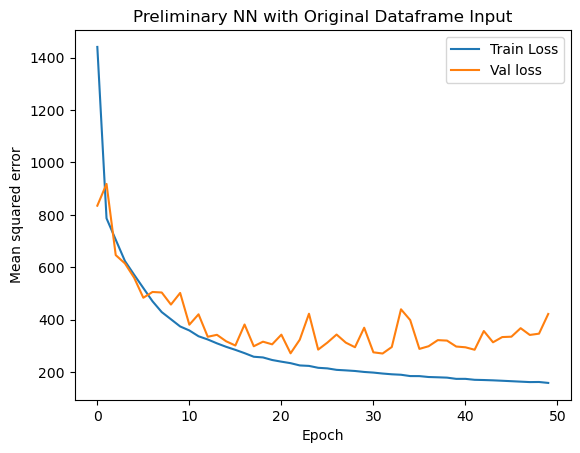

In [18]:
model_utils.plot_history(history)
plt.title('Preliminary NN with Original Dataframe Input')

- Indicates that the model isn't generalizing well
- While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
    - Completely fine, just signals that hyperparameter tuning will be needed (as expected)

In [ ]:
#Normalize so more comparable to other plot

In [ ]:
#history.history.keys()

In [ ]:
#norm_loss = (history.history['loss'] - np.mean(history.history['loss'])) / np.std(history.history['loss'])

In [ ]:
#norm_val_loss = (history.history['val_loss'] - np.mean(history.history['val_loss'])) / np.std(history.history['val_loss'])

In [ ]:
#x_ax = history.epoch
#plt.plot(x_ax, norm_loss, label="training")
#plt.plot(x_ax, norm_val_loss, label="validation")
#plt.title("Normalized Training and Validation Loss over Epochs")
#plt.legend()
#plt.show()

## Save NN Model

In [19]:
# after training, save:
NN_model.save(os.path.join(recon_model_path,'NN_model_prelim_originaldfupdated.h5'))

## Test NN Model

In [20]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(recon_model_path,'NN_model_prelim_originaldfupdated.h5'))

In [21]:
y_pred = NN_prelim_model.predict(X_test_df)
mse_originaldfupdated = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse_originaldfupdated)

1488/1488 [==============================] - 1s 726us/step
MSE: 231.34


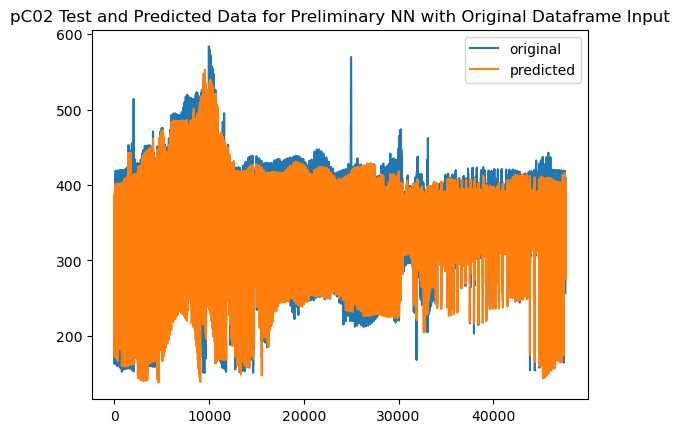

In [22]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Original Dataframe Input")
plt.legend()
plt.show()

# Preliminary NN Model using Original Numpy Input

## Build NN Model

In [23]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [24]:
X_train_original.shape[1]

10

In [25]:
NN_model_on = Sequential()

NN_model_on.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_original.shape[1],))) #  the 1st hidden layer 
NN_model_on.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_on.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_on.add(Dense(1,  activation='linear')) # the output layer


NN_model_on.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [26]:
NN_model_on.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_on = NN_model_on.fit(X_train_original, y_train_original, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1483.0913 - val_loss: 859.9924
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 789.3325 - val_loss: 731.0333
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 732.5063 - val_loss: 756.5519
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 663.0201 - val_loss: 630.2083
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 614.8088 - val_loss: 599.3781
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 548.5491 - val_loss: 594.3941
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 486.9538 - val_loss: 494.0406
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 434.9357 - val_loss: 458.6545
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 402.1085 - val_loss: 480.7994
Epoch 10/50
2483/2483 [======================

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Original Numpy Input')

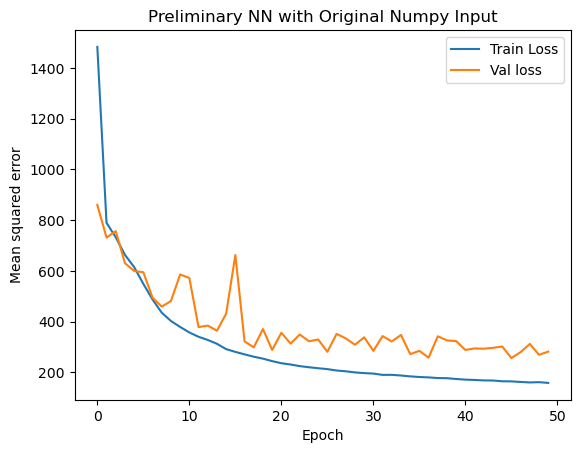

In [28]:
model_utils.plot_history(history_on)
plt.title('Preliminary NN with Original Numpy Input')

## Save NN Model

In [29]:
# after training, save:
NN_model_on.save(os.path.join(recon_model_path,'NN_model_prelim_originalnumpyupdated.h5'))

## Test NN Model

In [30]:
NN_model_on = load_model(os.path.join(recon_model_path,'NN_model_prelim_originalnumpyupdated.h5'))

In [31]:
y_pred_on = NN_model_on.predict(X_test_original)
mse_originalnumpyupdated = mean_squared_error(y_test_original, y_pred_on)
print("MSE: %.2f" % mse_originalnumpyupdated)

1488/1488 [==============================] - 1s 724us/step
MSE: 194.80


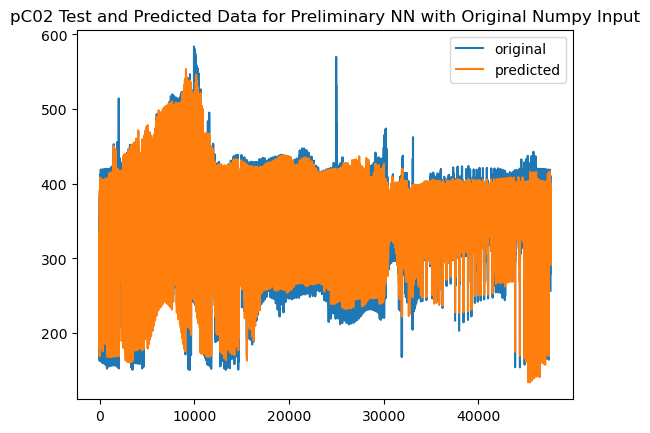

In [32]:
x_ax = range(len(y_test_original))
plt.plot(x_ax, y_test_original, label="original")
plt.plot(x_ax, y_pred_on, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Original Numpy Input")
plt.legend()
plt.show()

# Preliminary NN Model using Normalized Input

## Build NN Model

In [33]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [34]:
X_train_df_norm.shape[1]

10

In [35]:
NN_model_nprelim = Sequential()

NN_model_nprelim.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_df_norm.shape[1],))) #  the 1st hidden layer 
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nprelim.add(Dense(1,  activation='linear')) # the output layer


NN_model_nprelim.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [36]:
NN_model_nprelim.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                704       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [37]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nprelim = NN_model_nprelim.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 0.2197 - val_loss: 0.1949
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1271 - val_loss: 0.1874
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1072 - val_loss: 0.1727
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0966 - val_loss: 0.1601
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0897 - val_loss: 0.2056
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0855 - val_loss: 0.1895
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0817 - val_loss: 0.1909
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0786 - val_loss: 0.1788
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0769 - val_loss: 0.1927
Epoch 10/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.075

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Normalized Dataframe Input')

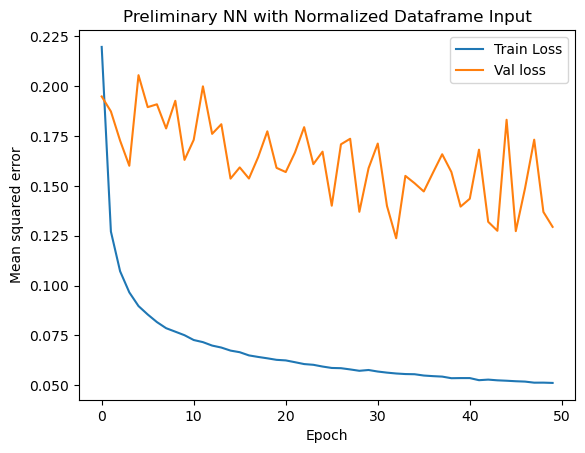

In [38]:
model_utils.plot_history(history_nprelim)
plt.title('Preliminary NN with Normalized Dataframe Input')

## Save NN Model

In [39]:
# after training, save:
NN_model_nprelim.save(os.path.join(recon_model_path,'NN_model_prelim_normdfupdated.h5'))

## Test NN Model

In [40]:
NN_model_nprelim = load_model(os.path.join(recon_model_path,'NN_model_prelim_normdfupdated.h5'))

In [41]:
y_pred_nprelim = NN_model_nprelim.predict(X_test_df_norm)
mse_normdfupdated = mean_squared_error(y_test_df_norm, y_pred_nprelim)
print("MSE: %.2f" % mse_normdfupdated)

1488/1488 [==============================] - 1s 656us/step
MSE: 0.09


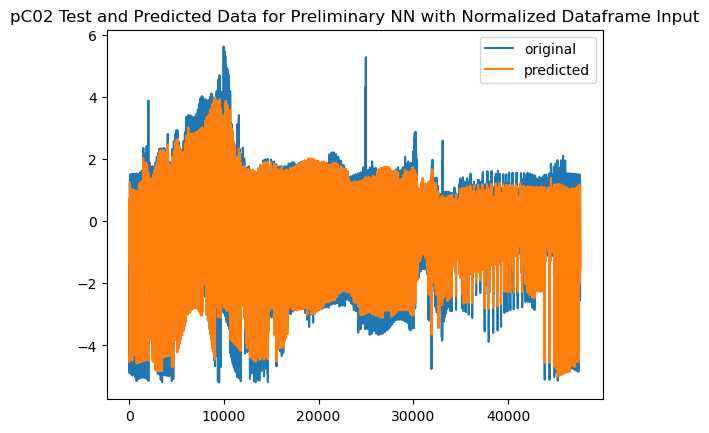

In [42]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred_nprelim, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Normalized Dataframe Input")
plt.legend()
plt.show()

# Preliminary NN Model using Normalized Numpy Input

## Build NN Model

In [43]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [44]:
X_train_n.shape[1]

10

In [45]:
NN_model_nn = Sequential()

NN_model_nn.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_n.shape[1],))) #  the 1st hidden layer 
NN_model_nn.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nn.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nn.add(Dense(1,  activation='linear')) # the output layer


NN_model_nn.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [46]:
NN_model_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                704       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [47]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nn = NN_model_nn.fit(X_train_n, y_train_n, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.2158 - val_loss: 0.2120
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1237 - val_loss: 0.1637
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1082 - val_loss: 0.2252
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0999 - val_loss: 0.1594
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0942 - val_loss: 0.1826
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0905 - val_loss: 0.1650
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0855 - val_loss: 0.2115
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0837 - val_loss: 0.1768
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0810 - val_loss: 0.1700
Epoch 10/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.079

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Normalized Numpy Input')

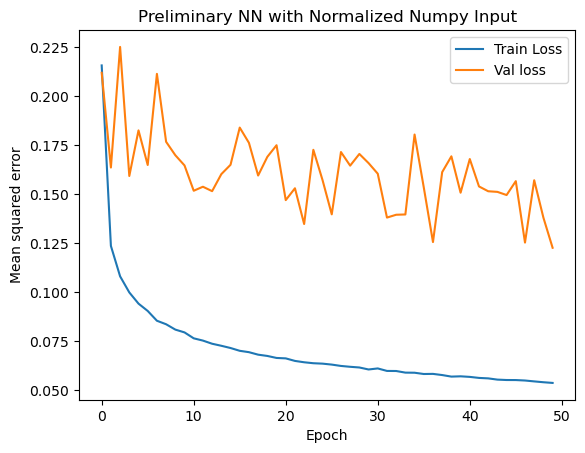

In [48]:
model_utils.plot_history(history_nn)
plt.title('Preliminary NN with Normalized Numpy Input')

## Save NN Model

In [49]:
# after training, save:
NN_model_nn.save(os.path.join(recon_model_path,'NN_model_prelim_normnumpyupdated.h5'))

## Test NN Model

In [50]:
NN_model_nn = load_model(os.path.join(recon_model_path,'NN_model_prelim_normnumpyupdated.h5'))

In [51]:
y_pred_nn = NN_model_nn.predict(X_test_n)
mse_normnumpyupdated = mean_squared_error(y_test_n, y_pred_nn)
print("MSE: %.2f" % mse_normnumpyupdated)

1488/1488 [==============================] - 1s 668us/step
MSE: 0.09


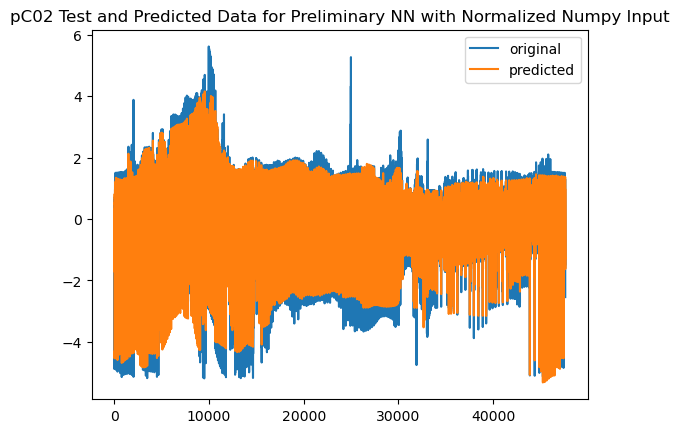

In [52]:
x_ax = range(len(y_test_n))
plt.plot(x_ax, y_test_n, label="original")
plt.plot(x_ax, y_pred_nn, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Normalized Numpy Input")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on original dataframes
- Comparison completed above for group reference, as data has not historically been normalized prior to training
- Regarding normalization
    - Likely need to debug or investigate normalizing specific input parameters
    - For both the dataframe and numpy normalized inputs, validation losses did not decrease with training losses. This could mean overfitting to the training set; maybe normalization makes it "too easy" for the algorithm to learn the training set.
- Regarding dataframe vs numpy array
    - The difference between dataframe and numpy input is likely not significant, as runs for original and normalized data were similar. 
    - NN based on original dataframe input had a slightly higher MSE than that based on the numpy input, but the difference likely was not significant/could be due to random variation in runs. 
    - Visually, use of the original dataframe resulted in more closely aligned predicted pCO2, particularly at the extremes. 

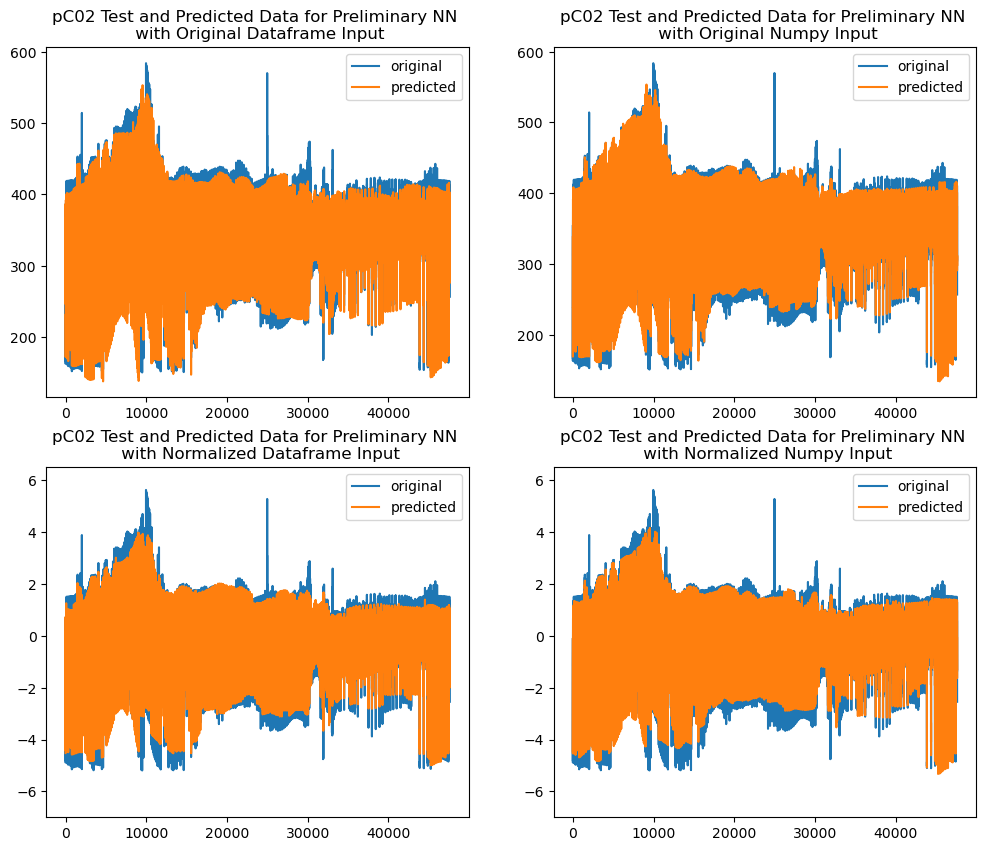

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(12,10))

r1 = range(len(y_test_df))
ax1.plot(r1, y_test_df, label="original")
ax1.plot(r1, y_pred, label="predicted")
ax1.set_title("pC02 Test and Predicted Data for Preliminary NN \n with Original Dataframe Input")
ax1.legend()


r2 = range(len(y_test_original))
ax2.plot(r2, y_test_original, label="original")
ax2.plot(r2, y_pred_on, label="predicted")
ax2.set_title("pC02 Test and Predicted Data for Preliminary NN \n with Original Numpy Input")
ax2.legend()


r3 = range(len(y_test_df_norm))
ax3.plot(r3, y_test_df_norm, label="original")
ax3.plot(r3, y_pred_nprelim, label="predicted")
ax3.set_title("pC02 Test and Predicted Data for Preliminary NN \n with Normalized Dataframe Input")
ax3.set_ylim(-7,6.5) #make y axis of norm plots match for easier comparison
ax3.legend()


r4 = range(len(y_test_n))
ax4.plot(r4, y_test_n, label="original")
ax4.plot(r4, y_pred_nn, label="predicted")
ax4.set_title("pC02 Test and Predicted Data for Preliminary NN \n with Normalized Numpy Input")
ax4.set_ylim(-7,6.5)  #make y axis of norm plots match for easier comparison
ax4.legend()

In [54]:
print("MSE for Original DataFrame: %.2f" % mse_originaldfupdated)
print("MSE for Original NumPy: %.2f" % mse_originalnumpyupdated)
print("MSE for Normalized DataFrame: %.2f" % mse_normdfupdated)
print("MSE for Normalized NumPy: %.2f" % mse_normnumpyupdated)

MSE for Original DataFrame: 231.34
MSE for Original NumPy: 194.80
MSE for Normalized DataFrame: 0.09
MSE for Normalized NumPy: 0.09


## Parameters

Experimentation with hyperparameters completed below

### Experiment with NN Model

In [ ]:
# First Run
#n_neuron       = 100
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 124.3420 - val_loss: 289.1165
# MSE: 181.18
# stopped after 91 epochs 

In [ ]:
# Second Run
#n_neuron       = 64
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.0015
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_4')) # added a 4th layer

# loss: mid 100s - val_loss: mid 300s
# MSE: 228.09
# stopped after 49 epochs 

In [ ]:
# Third Run
#n_neuron       = 64
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_4')) # added a 4th layer

#loss: 193.3637 - val_loss: 375.5946
# MSE:
# stopped after 40 epochs, but at start was much more aligned

In [ ]:
# 4th and 5th runs
#n_neuron       = 64
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 64
#model_num      = 1
# and made only two hidden layers 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# MSE: 289.26, loss: 257.6627 - val_loss: 366.7357 but trend MUCH more aligned, up patience from 10 to 20, and try Relu

# MSE: 267.70, loss: 225.0135 - val_loss: 318.7133, trend aligned even more, through almost all epochs

In [ ]:
# 6th run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0008
#minibatch_size = 64
#model_num      = 1
# and made only two hidden layers 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# ran for 74 epochs
# MSE: 255.24, loss: 180.7052 - val_loss: 294.3801 
# train/val trend not quite as aligned as previous run
# go back to first run and start again from there
# common between first run and this one: higher number of neurons, up again

In [ ]:
# 7th Run and 8th Run
#n_neuron       = 150
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 178.2955 - val_loss: 316.7465
# definitely not, trend not great again --> try with Relu instead of Leaky 
# MSE: 219.80, 162.3405 - val_loss: 343.4025

In [ ]:
# 9th Run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# MSE: 208.60, loss: 170.7158 - val_loss: 282.2546
# good train/val loss alignment but stopped at 64 epochs

In [ ]:
# 10th Run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 100
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#loss: 186.7061 - val_loss: 267.3068, MSE: 238.85
# but, best alignment between train and val loss so far
# take best run so far and increase batch size

Take best trends of all runs
- Relu over LeakyRelu
- Increase mini batch size to 100
- Don't alter neurons (worse when increase and decrease)
- Maintain learning rate, but maybe could go down, 0.0005 did well

In [70]:
# 11th and 12th Run and 13th run **12th is saved, 13th just swapped back to Leaky Relu **was worse, back to run 12
n_neuron       = 100
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.0005 # 0.002 definitely overtrained, val didn't decrease after approx 20 epochs, loss: 144.7867 - val_loss: 389.3859, MSE 208
minibatch_size = 100
model_num      = 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 143.5514 - val_loss: 239.9906
# MSE: 192.47
# ran all 100 epochs, and really consistent train val losses

In [71]:
NN_model_exp = Sequential()

NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_1', input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_2')) # the 2nd hidden layer
NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_3')) 
NN_model_exp.add(Dense(1, activation='linear', name='output_layer')) # the output layer


NN_model_exp.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [72]:
NN_model_exp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1100      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


### Train Experimental NN Model

In [ ]:
history_exp = NN_model_exp.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

### Initial Checks on Experimental NN Model

In [ ]:
model_utils.plot_history(history_exp)

In [ ]:
y_pred_exp = NN_model_exp.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_exp)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_exp, label="predicted")
plt.title("pC02 Test and Predicted Data for Optimized NN")
plt.legend()
plt.show()

### Save Best Experimental NN Model as First of NN Below, then Re-Run and Save as Second

In [ ]:
# after training, save:
NN_model_exp.save(os.path.join(recon_model_path,'NN_model1.h5'))

# Identical NN Models 

## NN Model 1

In [66]:
NN_model1 = load_model(os.path.join(recon_model_path,'NN_model1.h5'))

In [69]:
NN_model1.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1100      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


In [68]:
y_pred1 = NN_model1.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred1)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 620us/step
MSE: 192.47


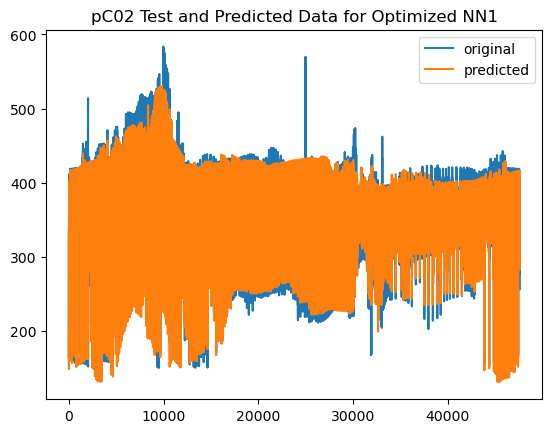

In [80]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred1, label="predicted")
plt.title("pC02 Test and Predicted Data for Optimized NN1")
plt.legend()
plt.show()

In [118]:
y_test_df['pred_pCO2'] = y_pred1
y_comparison = y_test_df.to_xarray().transpose('time','ylat','xlon')

Text(0.5, 1.0, 'pC02 Predicted Data in September 2016')

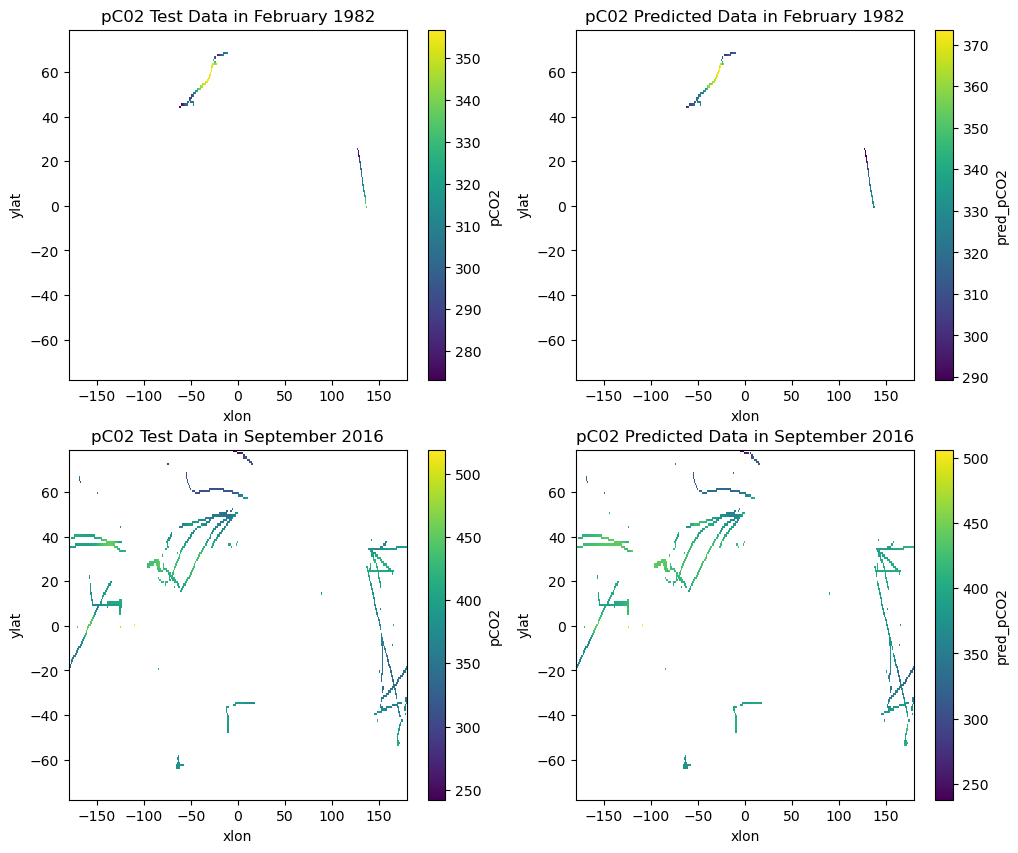

In [122]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(12,10))

y_comparison.pCO2[0,:,:].plot(ax=ax1)
ax1.set_title('pC02 Test Data in February 1982')

y_comparison.pred_pCO2[0,:,:].plot(ax=ax2)
ax2.set_title('pC02 Predicted Data in February 1982')

y_comparison.sel(time='2016-9-15').pCO2.plot(ax=ax3)
ax3.set_title('pC02 Test Data in September 2016')

y_comparison.sel(time='2016-9-15').pred_pCO2.plot(ax=ax4)
ax4.set_title('pC02 Predicted Data in September 2016')

## NN Model 2

In actual research project, remember to train five identical models to capture randomness/variation

In [ ]:
#NN_model2 = load_model(os.path.join(recon_model_path,'NN_model2.h5'))

In [ ]:
#NN_model2.summary()

In [ ]:
#y_pred2 = NN_model2.predict(X_test_df)
#mse = mean_squared_error(y_test_df, y_pred2)
#print("MSE: %.2f" % mse)

In [ ]:
#x_ax = range(len(y_test_df))
#plt.plot(x_ax, y_test_df, label="original")
#plt.plot(x_ax, y_pred1, label="predicted")
#plt.title("pC02 Test and Predicted Data for Optimized NN2")
#plt.legend()
#plt.show()

## NN Model 3

In actual research project, remember to train five identical models to capture randomness/variation

## NN Model 4

In actual research project, remember to train five identical models to capture randomness/variation

## NN Model 5

In actual research project, remember to train five identical models to capture randomness/variation